<a href="https://colab.research.google.com/github/JaeminKIM-Irene/FC_AI_ML_Project/blob/main/ML_Project_LightGBM_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 설치에 필요한 라이브러리들이 있다면 모두 적어둡니다. anaconda에 기본적으로 설치되지 않은 라이브러리들을 적어두세요.
!pip install lightgbm optuna

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

import optuna

from sklearn.model_selection import StratifiedKFold
from functools import partial

from sklearn.metrics import roc_auc_score

In [3]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# read data
result_list = []
base_url = '/content/drive/MyDrive/Colab Notebooks/data/playground-series-s3e23/'
train = pd.read_csv(base_url+'train.csv', index_col='id')
test = pd.read_csv(base_url+'test.csv', index_col='id')
submission = pd.read_csv(base_url+'sample_submission.csv', index_col='id')

with pd.option_context('display.min_rows', 6) :
  display(train)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101760,26.0,1.0,1.0,1.0,83.0,360.17,0.04,22.75,12.56,5893.69,...,20,0,4,0,10.0,8.0,51.0,28.0,1.0,False
101761,10.0,2.0,1.0,2.0,43.0,191.76,0.15,6.46,29.53,1534.04,...,7,0,1,0,11.0,14.0,24.0,19.0,3.0,False
101762,136.0,18.0,18.0,1.0,296.0,1704.57,0.02,44.82,44.08,77011.02,...,102,1,11,0,22.0,31.0,162.0,135.0,35.0,False


In [5]:
X = train.drop(columns=['defects'])
y = train.defects

In [34]:
# PCA Flag
feature_reducing = True

In [8]:
# PCA
if feature_reducing :
  from sklearn.decomposition import PCA

  pca = PCA(n_components=0.95,
            whiten=True,
            random_state=61)
  pca.fit(X)
  pca_df = pd.DataFrame(data=pca.transform(X))
  display(pca_df)

,0
0,-0.080883
1,-0.104576
2,-0.100283
3,-0.107008
4,-0.107576
...,...
101758,-0.105233
101759,-0.050322
101760,-0.078545
101761,-0.101438


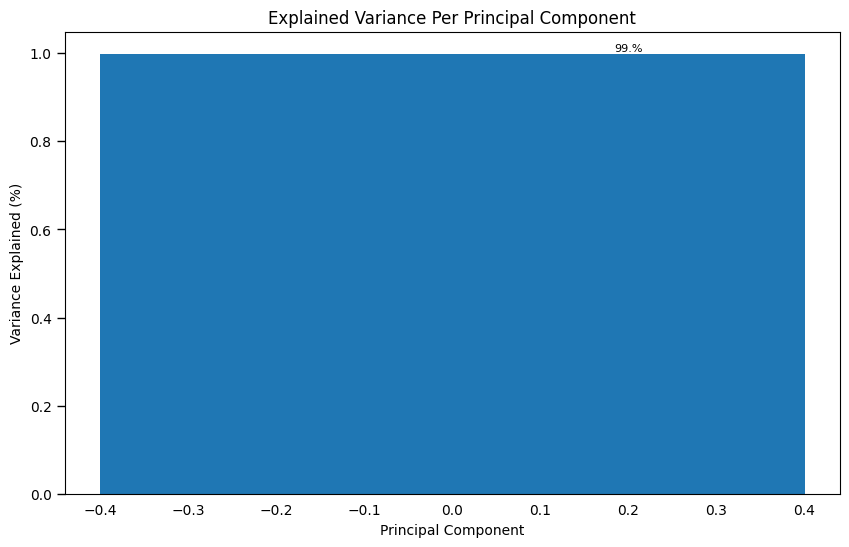

In [29]:
def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_

    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(round(vals[i]*100,1))[:3])), (ind[i]+0.2, vals[i]),
                    va="bottom",
                    ha="center",
                    fontsize=8)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=1, length=6)

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
scree_plot(pca)

In [9]:
# data split for baseline model
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(pca_df, y, test_size=0.05, random_state=61)

In [10]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(96674, 1) (96674,) (5089, 1) (5089,)


## Baseline Model

In [6]:
# data split for baseline model
from sklearn.model_selection import train_test_split

X = train.drop(columns=['defects'])
y = train.defects

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=61)

In [11]:
model = LGBMClassifier()

model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 21922, number of negative: 74752
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 96674, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226762 -> initscore=-1.226685
[LightGBM] [Info] Start training from score -1.226685


LGBMClassifier()

In [12]:
print('======Prediction======')
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)

train_score = roc_auc_score(y_train, pred_train)
val_score = roc_auc_score(y_val, pred_val)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % val_score)

======Prediction======
Train Score : 0.6488
Test Score : 0.6315


In [8]:
from sklearn.decomposition import PCA

model = Pipeline([('scale', StandardScaler()), ('reduce_dims', PCA(n_components=0.90, random_state=61)), ('clf', LGBMClassifier())])
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_val = model.predict(X_val)

train_score = roc_auc_score(y_train, pred_train)
val_score = roc_auc_score(y_val, pred_val)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % val_score)

[LightGBM] [Info] Number of positive: 21922, number of negative: 74752
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 96674, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226762 -> initscore=-1.226685
[LightGBM] [Info] Start training from score -1.226685
Train Score : 0.6730
Test Score : 0.6581


## Optuna

In [17]:
def optimizer(trial, X, y, K) :
  #num_leaves = trial.suggest_categorical('num_leaves', [64, 128, 256, 512])
  num_leaves=64
  max_depth = trial.suggest_int('max_depth', 10, 25)
  #learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3)
  learning_rate=0.030278064653420228
  min_child_samples = trial.suggest_int('min_child_samples', 1, 100)
  colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 0.8)

  model = Pipeline([
      ('scale', StandardScaler()),
      ('reduce_dims', PCA(n_components=0.90, random_state=61)),
      ('clf', LGBMClassifier(num_leaves=num_leaves,
                            max_depth=max_depth,
                            learning_rate=learning_rate,
                            min_child_samples=min_child_samples,
                            colsample_bytree=colsample_bytree,
                            random_state=61))])

  folds = StratifiedKFold(shuffle=True, random_state=61)
  oof = np.full(len(train), np.nan)
  auc_list = []

  for train_idx, val_idx in folds.split(X, y) :
    X_train = X.iloc[train_idx, :]
    y_train = y.iloc[train_idx]

    X_val = X.iloc[val_idx, :]
    y_val = y.iloc[val_idx]

    model.fit(X_train, y_train)

    try :
      y_val_pred = model.predict_proba(X_val)[:, 1]
    except :
      y_val_pred = model.decision_function(X_val)
    oof[val_idx] = y_val_pred
    auc = roc_auc_score(y_val, y_val_pred)
    auc_list.append(auc)

  return np.mean(auc_list)

In [18]:
K = 5
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

study = optuna.create_study(direction='maximize')
study.optimize(opt_func, n_trials=50)

[I 2023-10-16 07:39:12,996] A new study created in memory with name: no-name-8ce8ef67-81f7-4cea-aedc-01ed5bc5c42e


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:39:21,073] Trial 0 finished with value: 0.7844967102858711 and parameters: {'max_depth': 19, 'min_child_samples': 91, 'colsample_bytree': 0.6792116773619657}. Best is trial 0 with value: 0.7844967102858711.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:39:32,407] Trial 1 finished with value: 0.78438794252321 and parameters: {'max_depth': 15, 'min_child_samples': 77, 'colsample_bytree': 0.5938935412837442}. Best is trial 0 with value: 0.7844967102858711.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:39:39,136] Trial 2 finished with value: 0.784351930962213 and parameters: {'max_depth': 21, 'min_child_samples': 48, 'colsample_bytree': 0.6023982086444924}. Best is trial 0 with value: 0.7844967102858711.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:39:46,966] Trial 3 finished with value: 0.7826176083163487 and parameters: {'max_depth': 22, 'min_child_samples': 70, 'colsample_bytree': 0.5379214914809876}. Best is trial 0 with value: 0.7844967102858711.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:39:54,015] Trial 4 finished with value: 0.7842638691197299 and parameters: {'max_depth': 15, 'min_child_samples': 87, 'colsample_bytree': 0.7839130814253207}. Best is trial 0 with value: 0.7844967102858711.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:40:02,176] Trial 5 finished with value: 0.7845170833604682 and parameters: {'max_depth': 20, 'min_child_samples': 93, 'colsample_bytree': 0.623458582039218}. Best is trial 5 with value: 0.7845170833604682.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:40:09,147] Trial 6 finished with value: 0.784354502876585 and parameters: {'max_depth': 24, 'min_child_samples': 67, 'colsample_bytree': 0.7880929600987323}. Best is trial 5 with value: 0.7845170833604682.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:40:17,257] Trial 7 finished with value: 0.7844286246619088 and parameters: {'max_depth': 24, 'min_child_samples': 66, 'colsample_bytree': 0.6668216489275065}. Best is trial 5 with value: 0.7845170833604682.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:40:23,979] Trial 8 finished with value: 0.7845251994420086 and parameters: {'max_depth': 16, 'min_child_samples': 91, 'colsample_bytree': 0.5948781817782184}. Best is trial 8 with value: 0.7845251994420086.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:40:32,108] Trial 9 finished with value: 0.7842219248216734 and parameters: {'max_depth': 18, 'min_child_samples': 54, 'colsample_bytree': 0.6032344425675735}. Best is trial 8 with value: 0.7845251994420086.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:40:38,363] Trial 10 finished with value: 0.7823721831172868 and parameters: {'max_depth': 10, 'min_child_samples': 6, 'colsample_bytree': 0.5051128444703711}. Best is trial 8 with value: 0.7845251994420086.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:40:46,538] Trial 11 finished with value: 0.7843986756560334 and parameters: {'max_depth': 14, 'min_child_samples': 100, 'colsample_bytree': 0.6576680504248356}. Best is trial 8 with value: 0.7845251994420086.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:40:53,610] Trial 12 finished with value: 0.7842840000566765 and parameters: {'max_depth': 12, 'min_child_samples': 26, 'colsample_bytree': 0.5644563529881645}. Best is trial 8 with value: 0.7845251994420086.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:41:01,853] Trial 13 finished with value: 0.7843583859493326 and parameters: {'max_depth': 17, 'min_child_samples': 99, 'colsample_bytree': 0.6104702961708006}. Best is trial 8 with value: 0.7845251994420086.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:41:08,872] Trial 14 finished with value: 0.784466759490037 and parameters: {'max_depth': 20, 'min_child_samples': 47, 'colsample_bytree': 0.7063095251493015}. Best is trial 8 with value: 0.7845251994420086.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:41:16,995] Trial 15 finished with value: 0.784382416263346 and parameters: {'max_depth': 17, 'min_child_samples': 80, 'colsample_bytree': 0.6278065457255315}. Best is trial 8 with value: 0.7845251994420086.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:41:23,732] Trial 16 finished with value: 0.7841258284476098 and parameters: {'max_depth': 22, 'min_child_samples': 30, 'colsample_bytree': 0.5694177050322422}. Best is trial 8 with value: 0.7845251994420086.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:41:31,804] Trial 17 finished with value: 0.7843837208842986 and parameters: {'max_depth': 13, 'min_child_samples': 85, 'colsample_bytree': 0.6364634455005121}. Best is trial 8 with value: 0.7845251994420086.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:41:38,285] Trial 18 finished with value: 0.7825850430313762 and parameters: {'max_depth': 16, 'min_child_samples': 57, 'colsample_bytree': 0.5338511952616457}. Best is trial 8 with value: 0.7845251994420086.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:41:46,742] Trial 19 finished with value: 0.7842498840521659 and parameters: {'max_depth': 19, 'min_child_samples': 93, 'colsample_bytree': 0.7068603197324426}. Best is trial 8 with value: 0.7845251994420086.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:41:53,570] Trial 20 finished with value: 0.7843830873311328 and parameters: {'max_depth': 25, 'min_child_samples': 76, 'colsample_bytree': 0.6358922605840032}. Best is trial 8 with value: 0.7845251994420086.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:42:02,311] Trial 21 finished with value: 0.7844950764101972 and parameters: {'max_depth': 19, 'min_child_samples': 90, 'colsample_bytree': 0.6632659844584429}. Best is trial 8 with value: 0.7845251994420086.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:42:10,330] Trial 22 finished with value: 0.7842498840521659 and parameters: {'max_depth': 19, 'min_child_samples': 93, 'colsample_bytree': 0.6889302826538464}. Best is trial 8 with value: 0.7845251994420086.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:42:17,856] Trial 23 finished with value: 0.7844827178030863 and parameters: {'max_depth': 21, 'min_child_samples': 100, 'colsample_bytree': 0.5762301271654711}. Best is trial 8 with value: 0.7845251994420086.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:42:25,378] Trial 24 finished with value: 0.7843833262279425 and parameters: {'max_depth': 18, 'min_child_samples': 84, 'colsample_bytree': 0.6299052327333431}. Best is trial 8 with value: 0.7845251994420086.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:42:32,895] Trial 25 finished with value: 0.7843889941901155 and parameters: {'max_depth': 16, 'min_child_samples': 75, 'colsample_bytree': 0.6734629936439019}. Best is trial 8 with value: 0.7845251994420086.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:42:41,017] Trial 26 finished with value: 0.784638184861284 and parameters: {'max_depth': 20, 'min_child_samples': 61, 'colsample_bytree': 0.7234385199718164}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:42:48,346] Trial 27 finished with value: 0.7845831363119883 and parameters: {'max_depth': 22, 'min_child_samples': 38, 'colsample_bytree': 0.7175390408053408}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:42:56,284] Trial 28 finished with value: 0.7842259027970224 and parameters: {'max_depth': 23, 'min_child_samples': 27, 'colsample_bytree': 0.7403079448310138}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:43:03,497] Trial 29 finished with value: 0.7844479300456927 and parameters: {'max_depth': 21, 'min_child_samples': 38, 'colsample_bytree': 0.7545727631254946}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:43:11,578] Trial 30 finished with value: 0.7842462000867005 and parameters: {'max_depth': 23, 'min_child_samples': 14, 'colsample_bytree': 0.7298217401967207}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:43:18,665] Trial 31 finished with value: 0.7843160340333355 and parameters: {'max_depth': 20, 'min_child_samples': 39, 'colsample_bytree': 0.6974478832264239}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:43:26,675] Trial 32 finished with value: 0.7842906610325523 and parameters: {'max_depth': 20, 'min_child_samples': 61, 'colsample_bytree': 0.6807382977899628}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:43:33,419] Trial 33 finished with value: 0.7843894498161281 and parameters: {'max_depth': 22, 'min_child_samples': 44, 'colsample_bytree': 0.6495569121651052}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:43:41,832] Trial 34 finished with value: 0.7843420111007194 and parameters: {'max_depth': 21, 'min_child_samples': 34, 'colsample_bytree': 0.7235758682681375}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:43:48,545] Trial 35 finished with value: 0.7842695741185215 and parameters: {'max_depth': 16, 'min_child_samples': 52, 'colsample_bytree': 0.6162322813476587}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:43:56,694] Trial 36 finished with value: 0.7843521141633825 and parameters: {'max_depth': 18, 'min_child_samples': 72, 'colsample_bytree': 0.5906221544845068}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:44:03,693] Trial 37 finished with value: 0.7843729378728961 and parameters: {'max_depth': 23, 'min_child_samples': 62, 'colsample_bytree': 0.7722507796602155}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:44:11,844] Trial 38 finished with value: 0.7844132859553637 and parameters: {'max_depth': 15, 'min_child_samples': 81, 'colsample_bytree': 0.6524761781315227}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:44:18,407] Trial 39 finished with value: 0.7842150017210304 and parameters: {'max_depth': 20, 'min_child_samples': 21, 'colsample_bytree': 0.6868333990370676}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:44:26,758] Trial 40 finished with value: 0.7843315651495312 and parameters: {'max_depth': 25, 'min_child_samples': 68, 'colsample_bytree': 0.7657748029627287}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:44:33,788] Trial 41 finished with value: 0.7845241947895841 and parameters: {'max_depth': 22, 'min_child_samples': 94, 'colsample_bytree': 0.7983923803409375}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:44:42,299] Trial 42 finished with value: 0.784340297559789 and parameters: {'max_depth': 22, 'min_child_samples': 95, 'colsample_bytree': 0.787912182922414}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:44:49,323] Trial 43 finished with value: 0.7842287903519478 and parameters: {'max_depth': 24, 'min_child_samples': 88, 'colsample_bytree': 0.7962598096321964}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:44:57,769] Trial 44 finished with value: 0.7844605473656118 and parameters: {'max_depth': 22, 'min_child_samples': 96, 'colsample_bytree': 0.7501197064943826}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:45:04,786] Trial 45 finished with value: 0.784275525000659 and parameters: {'max_depth': 21, 'min_child_samples': 80, 'colsample_bytree': 0.7770071164836503}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:45:13,179] Trial 46 finished with value: 0.7843280899365705 and parameters: {'max_depth': 19, 'min_child_samples': 89, 'colsample_bytree': 0.7214850220971185}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:45:20,153] Trial 47 finished with value: 0.7844314197838 and parameters: {'max_depth': 14, 'min_child_samples': 45, 'colsample_bytree': 0.7980805157601072}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:45:28,574] Trial 48 finished with value: 0.7843649265821411 and parameters: {'max_depth': 17, 'min_child_samples': 84, 'colsample_bytree': 0.762884221607005}. Best is trial 26 with value: 0.784638184861284.


[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGBM] [Info] Number of positive: 17538, number of negative: 59801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 77339, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226768 -> initscore=-1.226652
[LightGBM] [Info] Start training from score -1.226652
[LightGB

[I 2023-10-16 07:45:35,434] Trial 49 finished with value: 0.7842193171527747 and parameters: {'max_depth': 23, 'min_child_samples': 19, 'colsample_bytree': 0.7809591326296303}. Best is trial 26 with value: 0.784638184861284.


In [ ]:
# boosting type = dart

In [15]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_num_leaves,state
0,0,0.770301,2023-10-16 05:17:35.387827,2023-10-16 05:17:40.150510,0 days 00:00:04.762683,0.580134,0.171424,11,8,512,COMPLETE
1,1,0.770312,2023-10-16 05:17:40.152280,2023-10-16 05:17:46.009781,0 days 00:00:05.857501,0.724044,0.184544,11,24,256,COMPLETE
2,2,0.770177,2023-10-16 05:17:46.011590,2023-10-16 05:17:52.621830,0 days 00:00:06.610240,0.501949,0.197701,19,70,256,COMPLETE
3,3,0.770334,2023-10-16 05:17:52.623603,2023-10-16 05:17:57.071666,0 days 00:00:04.448063,0.711485,0.135746,12,89,64,COMPLETE
4,4,0.770147,2023-10-16 05:17:57.074728,2023-10-16 05:18:04.603526,0 days 00:00:07.528798,0.646875,0.257536,19,95,256,COMPLETE
5,5,0.770249,2023-10-16 05:18:04.610633,2023-10-16 05:18:09.854469,0 days 00:00:05.243836,0.599159,0.156969,20,35,128,COMPLETE
6,6,0.770308,2023-10-16 05:18:09.856473,2023-10-16 05:18:15.394622,0 days 00:00:05.538149,0.564816,0.128158,18,11,64,COMPLETE
7,7,0.770166,2023-10-16 05:18:15.397002,2023-10-16 05:18:22.730216,0 days 00:00:07.333214,0.669799,0.233965,20,73,256,COMPLETE
8,8,0.770298,2023-10-16 05:18:22.732327,2023-10-16 05:18:29.056045,0 days 00:00:06.323718,0.674883,0.223071,25,71,64,COMPLETE
9,9,0.770317,2023-10-16 05:18:29.059035,2023-10-16 05:18:33.127555,0 days 00:00:04.068520,0.540370,0.239699,10,100,128,COMPLETE


In [16]:
# is_balance=True
print('Best Score: %.4f' % study.best_value)
print('Best Params: ', study.best_trial.params)

Best Score: 0.7712
Best Params:  {'num_leaves': 64, 'max_depth': 14, 'learning_rate': 0.016844006148382676, 'min_child_samples': 19, 'colsample_bytree': 0.7083179082542116}


In [21]:
# fix learning rate 0.016844006148382676
print('Best Score: %.4f' % study.best_value)
print('Best Params: ', study.best_trial.params)

Best Score: 0.7712
Best Params:  {'num_leaves': 64, 'max_depth': 14, 'min_child_samples': 46, 'colsample_bytree': 0.7443738203689874}


In [25]:
# fix learning rate 0.016844006148382676, num_leaves 64
print('Best Score: %.4f' % study.best_value)
print('Best Params: ', study.best_trial.params)

Best Score: 0.7712
Best Params:  {'max_depth': 21, 'min_child_samples': 52, 'colsample_bytree': 0.5779275403612723}


In [ ]:
print('Best Score: %.4f' % study.best_value)
print('Best Params: ', study.best_trial.params)

Best Score: 0.7923
Best Params:  {'num_leaves': 64, 'max_depth': 14, 'learning_rate': 0.04151372498765896, 'min_child_samples': 64, 'colsample_bytree': 0.7039329213868132}


In [11]:
# Use pipeline for standardscaler
print('Best Score: %.4f' % study.best_value)
print('Best Params: ', study.best_trial.params)

Best Score: 0.7845
Best Params:  {'num_leaves': 64, 'max_depth': 22, 'learning_rate': 0.030278064653420228, 'min_child_samples': 30, 'colsample_bytree': 0.7974305378631804}


In [15]:
# Use pipeline for standardscaler & fix learning_rate 0.030278064653420228
print('Best Score: %.4f' % study.best_value)
print('Best Params: ', study.best_trial.params)

Best Score: 0.7847
Best Params:  {'num_leaves': 64, 'max_depth': 14, 'min_child_samples': 42, 'colsample_bytree': 0.7617328222470997}


In [19]:
# Use pipeline for standardscaler & fix learning_rate 0.030278064653420228 & num_leaves 64
print('Best Score: %.4f' % study.best_value)
print('Best Params: ', study.best_trial.params)

Best Score: 0.7846
Best Params:  {'max_depth': 20, 'min_child_samples': 61, 'colsample_bytree': 0.7234385199718164}


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [16]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)

## Test & Submission file

In [ ]:
def oof_preds(best_model) :
  folds = StratifiedKFold(shuffle=True, random_state=61)
  final_preds = []
  auc_list = []

  for i, (train_idx, val_idx) in enumerate(folds.split(X, y)) :
    X_train = X.iloc[train_idx, :]
    y_train = y.iloc[train_idx]
    X_val = X.iloc[val_idx, :]
    y_val = y.iloc[val_idx]

    print(f"========== Fold {i+1} ==========")
    best_model.fit(X_train, y_train)
    preds = best_model.predict_proba(X_val)[:, 1]
    test_preds = best_model.predict_proba(test)[:, 1]
    final_preds.append(test_preds)
    auc = roc_auc_score(y_val, preds)

    auc_list.append(auc)

  print(f'AUC :', np.mean(auc))
  return final_preds

In [ ]:
best_params = study.best_trial.params

best_model = LGBMClassifier(**best_params,
                            random_state=61)

preds = oof_preds(best_model)
preds = np.mean(preds, axis=0)

preds

========== Fold 1 ==========
[LightGBM] [Info] Number of positive: 18451, number of negative: 62959
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3547
[LightGBM] [Info] Number of data points in the train set: 81410, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226643 -> initscore=-1.227365
[LightGBM] [Info] Start training from score -1.227365
========== Fold 2 ==========
[LightGBM] [Info] Number of positive: 18451, number of negative: 62959
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 81410, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226643 -> initscore=-1.227365
[L

array([0.21875383, 0.18928986, 0.64816721, ..., 0.17000563, 0.10214024,
       0.80084926])

In [ ]:
submission.defects = preds

In [ ]:
submission.to_csv('submission_lightGBM_allparameters.csv')